# Triumph's Submission for Hamoye Internship Stage D Quiz

## Stage D: Neural Network, Image Recognition & Object Detection

### Import Libraries

In [2]:
import os
import warnings
import logging 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.style as style
import seaborn as sns
import tensorflow as tf
import tensorflow.keras.layers as tfl
import tensorflow_hub as hub

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Activation, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras import Sequential 
from keras.preprocessing import image
from PIL import Image
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation
from tensorflow_addons.metrics import FBetaScore

warnings.filterwarnings('ignore')
logging.getLogger("tensorflow").setLevel(logging.ERROR)

### Data Cleaning and Preparation

In [3]:
df_ori = pd.read_csv("../input/planets-dataset/planet/planet/train_classes.csv")

train_df = df_ori.copy()
train_df.head()

,image_name,tags
0,train_0,haze primary
1,train_1,agriculture clear primary water
2,train_2,clear primary
3,train_3,clear primary
4,train_4,agriculture clear habitation primary road


In [4]:
train_df.isnull().any().sum()

0

In [5]:
images = train_df["image_name"].nunique()
print(f"There are {images} images in our dataset.")

There are 40479 images in our dataset.


**Check label frequencies**

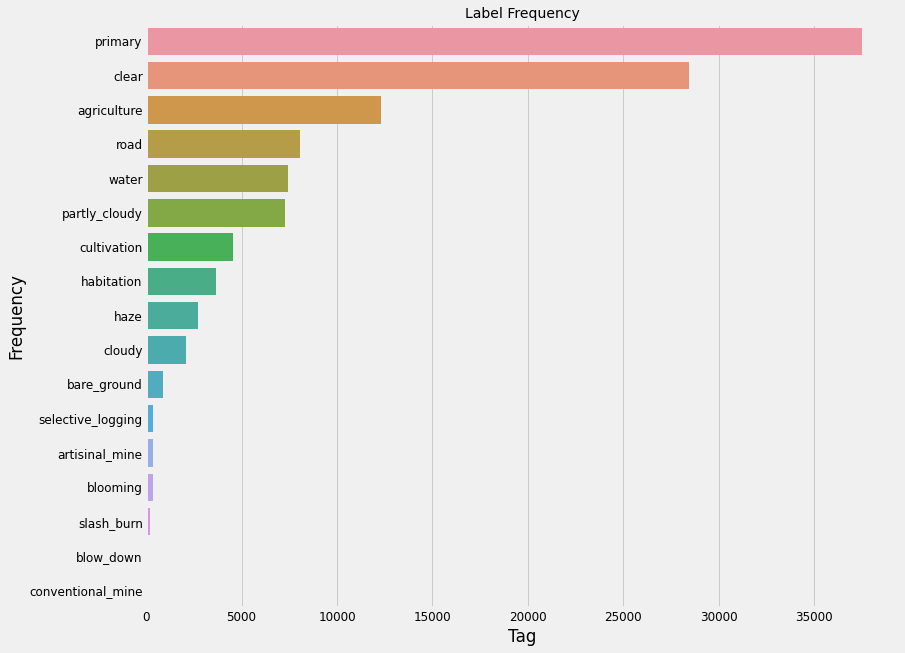

In [6]:
label_freq = train_df["tags"].apply(lambda s : str(s).split(" ")).explode().value_counts().sort_values(ascending = False)

style.use("fivethirtyeight")
plt.figure(figsize = (12, 10))
sns.barplot(y = label_freq.index.values, x = label_freq, order = label_freq.index)
plt.title("Label Frequency", fontsize = 14)
plt.xlabel("Tag")
plt.xticks(fontsize = 12)
plt.ylabel("Frequency")
plt.yticks(fontsize = 12)
plt.show()

In [7]:
rare = list(label_freq[label_freq < 800].index)
print("We will ignore these labels because they are too infrequent for our model to learn properly:", rare)

We will ignore these labels because they are too infrequent for our model to learn properly: ['selective_logging', 'artisinal_mine', 'blooming', 'slash_burn', 'blow_down', 'conventional_mine']


In [8]:
train_df["tags"] = train_df["tags"].apply(lambda s : [l for l in str(s).split(" ") if l not in rare])
train_df.head()

,image_name,tags
0,train_0,"[haze, primary]"
1,train_1,"[agriculture, clear, primary, water]"
2,train_2,"[clear, primary]"
3,train_3,"[clear, primary]"
4,train_4,"[agriculture, clear, habitation, primary, road]"


**Visualize Images**

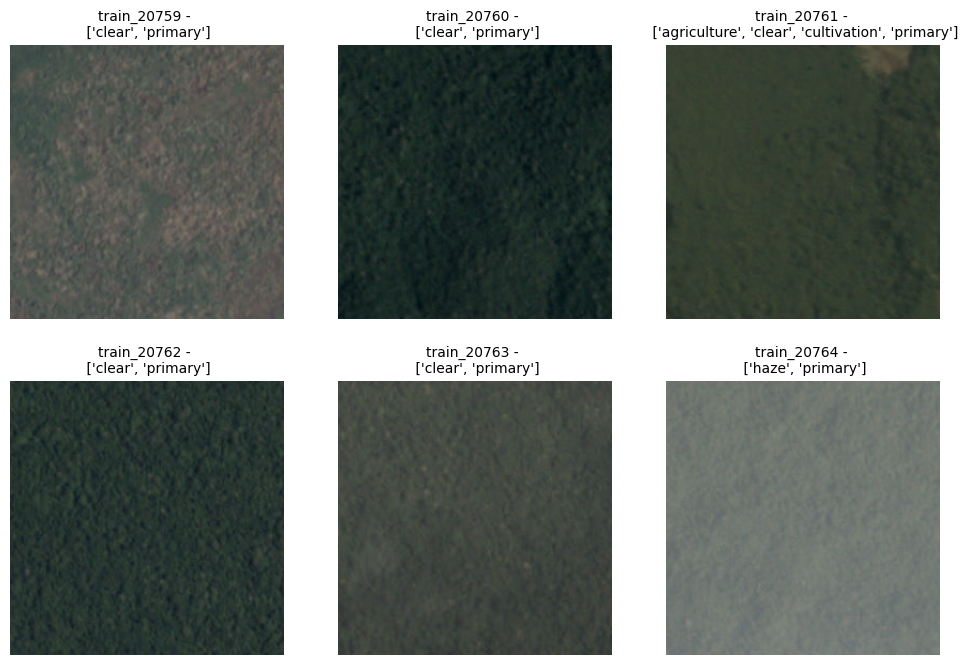

In [9]:
nobs = 6 # Number of observations to display
ncols = 3 # Number of columns in axis
nrows = nobs // ncols # Number of rows in axis

style.use("default")
plt.figure(figsize = (12, 4 * nrows))

random_img = np.random.randint(0, len(train_df) - nobs)

for i, (image_name, tag) in enumerate(train_df[random_img : random_img + nobs].values):
  ax = plt.subplot(nrows, ncols, i + 1)
  plt.imshow(Image.open("../input/planets-dataset/planet/planet/train-jpg/{}.jpg".format(image_name)))
  plt.title("{} - \n {}".format(image_name, tag), size = 10)
  plt.axis("off")

In [10]:
train_df["image_name"] = train_df["image_name"].apply(lambda x : "{}.jpg".format(x))
train_df.head()

,image_name,tags
0,train_0.jpg,"[haze, primary]"
1,train_1.jpg,"[agriculture, clear, primary, water]"
2,train_2.jpg,"[clear, primary]"
3,train_3.jpg,"[clear, primary]"
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]"


In [11]:
label_list = [ ]

for tag_list in train_df["tags"].values:
    for tag in tag_list:
        if tag not in label_list:
            label_list.append(tag)
            
print(label_list)
print("--" * 30)
print(f"There a total of {len(label_list)} unique labels in the dataset.")

['haze', 'primary', 'agriculture', 'clear', 'water', 'habitation', 'road', 'cultivation', 'cloudy', 'partly_cloudy', 'bare_ground']
------------------------------------------------------------
There a total of 11 unique labels in the dataset.


**Create Dummy Columns**

In [12]:
for label in label_list:
    train_df[label] = train_df["tags"].apply(lambda x: 1 if label in x else 0)
    
train_df.head()

,image_name,tags,haze,primary,agriculture,clear,water,habitation,road,cultivation,cloudy,partly_cloudy,bare_ground
0,train_0.jpg,"[haze, primary]",1,1,0,0,0,0,0,0,0,0,0
1,train_1.jpg,"[agriculture, clear, primary, water]",0,1,1,1,1,0,0,0,0,0,0
2,train_2.jpg,"[clear, primary]",0,1,0,1,0,0,0,0,0,0,0
3,train_3.jpg,"[clear, primary]",0,1,0,1,0,0,0,0,0,0,0
4,train_4.jpg,"[agriculture, clear, habitation, primary, road]",0,1,1,1,0,1,1,0,0,0,0


In [13]:
labels = list(train_df.columns[2:])
labels

['haze',
 'primary',
 'agriculture',
 'clear',
 'water',
 'habitation',
 'road',
 'cultivation',
 'cloudy',
 'partly_cloudy',
 'bare_ground']

### Image Preprocessing and Model Building

In [14]:
IMG_SIZE = 224
CHANNELS = 3
N_LABELS = len(label_list)

In [15]:
image_gen = ImageDataGenerator(rescale = 1. / 255,
                                   horizontal_flip = True,
                                   vertical_flip = True,
                                   rotation_range = 15, 
                                   shear_range = 0.1,
                                   validation_split = 0.20)

In [16]:
train_gen = image_gen.flow_from_dataframe(dataframe = train_df,
                                         directory = "../input/planets-dataset/planet/planet/train-jpg",
                                         x_col = "image_name",
                                         y_col = labels,
                                         target_size = (IMG_SIZE, IMG_SIZE), 
                                         seed = 42, 
                                         batch_size = 128,
                                         class_mode = "raw",
                                         subset = "training")

val_gen = image_gen.flow_from_dataframe(dataframe = train_df,
                                       directory = "../input/planets-dataset/planet/planet/train-jpg",
                                       x_col = "image_name",
                                       y_col = labels,
                                       target_size = (IMG_SIZE, IMG_SIZE), 
                                       seed = 42, 
                                       batch_size = 128,
                                       class_mode = "raw",
                                       subset = "validation")

Found 32384 validated image filenames.
Found 8095 validated image filenames.


**Load MobileNetV2 as feature extractor**

In [31]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/4"
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                        input_shape = (IMG_SIZE, IMG_SIZE, CHANNELS))

In [32]:
model = Sequential([
    feature_extractor_layer,
    Dropout(0.5),
    Dense(1024, 
         activation = "relu",
         kernel_regularizer=l2(0.01), 
         bias_regularizer=l2(0.01),
         name = "hidden_layer1"),
    Dropout(0.2),
     Dense(128, 
         activation = "relu",
         kernel_regularizer=l2(0.01), 
         bias_regularizer=l2(0.01),
         name = "hidden_layer2"),
    Dense(N_LABELS, 
          activation = "sigmoid",
          kernel_regularizer=l2(0.01),
          bias_regularizer=l2(0.01),
          name = "output_layer") # Output Layer
])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dropout_2 (Dropout)          (None, 1280)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 1024)              1311744   
_________________________________________________________________
dropout_3 (Dropout)          (None, 1024)              0         
_________________________________________________________________
hidden_layer2 (Dense)        (None, 128)               131200    
_________________________________________________________________
output_layer (Dense)         (None, 11)                1419      
Total params: 3,702,347
Trainable params: 1,444,363
Non-trainable params: 2,257,984
____________________________________

In [33]:
LR = 1e-5 # Keep it small when transfer learning
EPOCHS = 20

step_train_size = int(np.ceil(train_gen.samples / train_gen.batch_size))
step_val_size = int(np.ceil(val_gen.samples / val_gen.batch_size))

fbeta = FBetaScore(num_classes = N_LABELS,
                   average = 'weighted',
                   beta = 2.0,
                   threshold = 0.2,
                   name = 'fbeta')

In [34]:
model.compile(optimizer = Adam(learning_rate = LR),
             loss = "binary_crossentropy",
             metrics = [fbeta])

### Train Model

In [37]:
history = model.fit(train_gen, 
                   steps_per_epoch = step_train_size,
                   epochs = 20,
                   validation_data = val_gen,
                   validation_steps = step_val_size)

Epoch 1/20
253/253 [==============================] - 532s 2s/step - loss: 7.4192 - fbeta: 0.8300 - val_loss: 6.9286 - val_fbeta: 0.8508
Epoch 2/20
253/253 [==============================] - 531s 2s/step - loss: 6.5276 - fbeta: 0.8335 - val_loss: 6.0871 - val_fbeta: 0.8541
Epoch 3/20
253/253 [==============================] - 530s 2s/step - loss: 5.7286 - fbeta: 0.8394 - val_loss: 5.3342 - val_fbeta: 0.8569
Epoch 4/20
253/253 [==============================] - 532s 2s/step - loss: 5.0165 - fbeta: 0.8419 - val_loss: 4.6634 - val_fbeta: 0.8591
Epoch 5/20
253/253 [==============================] - 530s 2s/step - loss: 4.3829 - fbeta: 0.8441 - val_loss: 4.0678 - val_fbeta: 0.8612
Epoch 6/20
253/253 [==============================] - 529s 2s/step - loss: 3.8213 - fbeta: 0.8464 - val_loss: 3.5426 - val_fbeta: 0.8618
Epoch 7/20
253/253 [==============================] - 530s 2s/step - loss: 3.3258 - fbeta: 0.8478 - val_loss: 3.0789 - val_fbeta: 0.8623
Epoch 8/20
253/253 [=====================

In [29]:
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  fbeta = history.history['fbeta']
  val_fbeta = history.history['val_fbeta']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss Curve')
  plt.xlabel('Epochs')
  plt.ylabel("Loss")
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, fbeta, label='training_fbeta')
  plt.plot(epochs, val_fbeta, label='val_fbeta')
  plt.title('FBeta Curve')
  plt.xlabel('Epochs')
  plt.ylabel("fbeta")
  plt.legend();

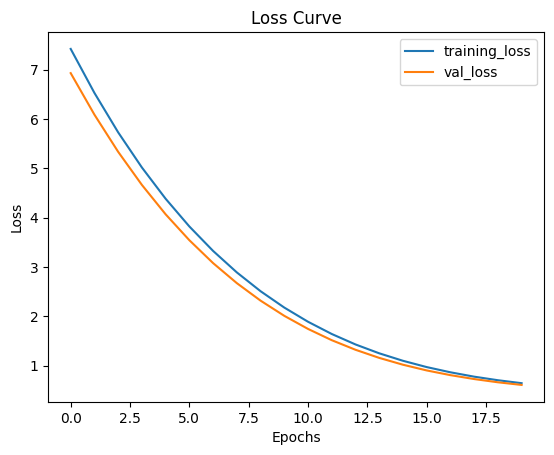

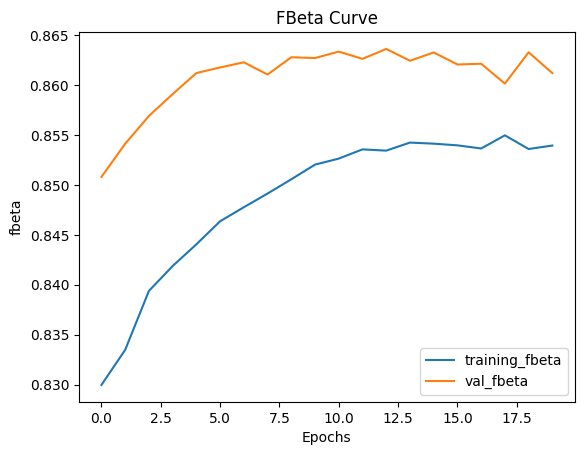

In [38]:
plot_loss_curves(history)

In [42]:
model.save("tuned_model.h5")

# Prediction on Test Set

In [63]:
test_gen = ImageDataGenerator(rescale = 1./255)

In [43]:
sample_submission = pd.read_csv("../input/planets-dataset/planet/planet/sample_submission.csv")

In [46]:
test_df = sample_submission.copy()
test_df["image_name"] = test_df["image_name"].apply(lambda x: "{}.jpg".format(x))
len(test_df)

61191

In [57]:
test1_df = test_df.iloc[:40669]["image_name"].reset_index()
test1_df.drop(columns = ["index"], inplace = True)
test1_df.head()

,image_name
0,test_0.jpg
1,test_1.jpg
2,test_2.jpg
3,test_3.jpg
4,test_4.jpg


In [65]:
test1_gen = test_gen.flow_from_dataframe(dataframe = test1_df,
                                        directory = "../input/planets-dataset/planet/planet/test-jpg",
                                        x_col = "image_name",
                                        y_col = None,
                                        target_size = (IMG_SIZE, IMG_SIZE),
                                        class_mode = None,
                                        shuffle = False,
                                        batch_size = 128)

Found 40669 validated image filenames.


In [66]:
step_test1_size = int(np.ceil(test1_gen.samples / test1_gen.batch_size))

In [67]:
test1_gen.reset()

pred1 = model.predict(test1_gen, steps = step_test1_size, verbose = 1)

318/318 [==============================] - 350s 1s/step


In [68]:
test1_file_names = test1_gen.filenames

pred1_tags = pd.DataFrame(pred1)
pred1_tags = pred1_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

result1 = pd.DataFrame({'image_name': test1_file_names, 'tags': pred1_tags})
result1.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [71]:
test2_df = test_df.iloc[40669:]['image_name'].reset_index()
test2_df.drop(columns = ['index'], inplace = True)
test2_df.head()

,image_name
0,file_0.jpg
1,file_1.jpg
2,file_10.jpg
3,file_100.jpg
4,file_1000.jpg


In [72]:
test2_gen = test_gen.flow_from_dataframe(dataframe = test2_df,
                                        directory = "../input/planets-dataset/test-jpg-additional/test-jpg-additional",
                                        x_col = "image_name",
                                        y_col = None,
                                        target_size = (IMG_SIZE, IMG_SIZE),
                                        class_mode = None,
                                        shuffle = False,
                                        batch_size = 128)

Found 20522 validated image filenames.


In [73]:
step_test2_size = int(np.ceil(test2_gen.samples / test2_gen.batch_size))

In [74]:
test2_gen.reset()

pred2 = model.predict(test2_gen, steps = step_test2_size, verbose = 1)

161/161 [==============================] - 173s 1s/step


In [75]:
test2_file_names = test2_gen.filenames

pred2_tags = pd.DataFrame(pred2)
pred2_tags = pred2_tags.apply(lambda x: ' '.join(np.array(labels)[x > 0.5]), axis = 1)

result2 = pd.DataFrame({'image_name': test2_file_names, 'tags': pred2_tags})
result2.head()

,image_name,tags
0,file_0.jpg,primary clear
1,file_1.jpg,primary agriculture clear road
2,file_10.jpg,primary
3,file_100.jpg,primary clear
4,file_1000.jpg,primary clear


In [78]:
final_result = pd.concat([result1, result2])

final_result.head()

,image_name,tags
0,test_0.jpg,primary clear
1,test_1.jpg,primary clear
2,test_2.jpg,primary partly_cloudy
3,test_3.jpg,primary clear
4,test_4.jpg,primary partly_cloudy


In [79]:
final_result['image_name'] = final_result['image_name'].str.replace('.jpg','')
final_result.head()

,image_name,tags
0,test_0,primary clear
1,test_1,primary clear
2,test_2,primary partly_cloudy
3,test_3,primary clear
4,test_4,primary partly_cloudy


**Save Predictions as .csv**

In [81]:
final_result.to_csv("Amazon_Image_Predictions.csv", index = False)